# Predict the acceptability of a car

In [23]:
%pip install scikit-learn
%pip install matplotlib
%pip install pandas

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [72]:
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn import preprocessing
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import StratifiedKFold, KFold, GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix

# EDA

In [25]:
df = pd.read_csv('../dataset/car.data', delimiter=',', header=None, names=['buying', 'maint', 'doors', 'persons', 'lug_boot', 'safety', 'class'])

df.info()

df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1728 entries, 0 to 1727
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   buying    1728 non-null   object
 1   maint     1728 non-null   object
 2   doors     1728 non-null   object
 3   persons   1728 non-null   object
 4   lug_boot  1728 non-null   object
 5   safety    1728 non-null   object
 6   class     1728 non-null   object
dtypes: object(7)
memory usage: 94.6+ KB


,buying,maint,doors,persons,lug_boot,safety,class
count,1728,1728,1728,1728,1728,1728,1728
unique,4,4,4,3,3,3,4
top,vhigh,vhigh,2,2,small,low,unacc
freq,432,432,432,576,576,576,1210


In [26]:
df.head(n=10)

,buying,maint,doors,persons,lug_boot,safety,class
0,vhigh,vhigh,2,2,small,low,unacc
1,vhigh,vhigh,2,2,small,med,unacc
2,vhigh,vhigh,2,2,small,high,unacc
3,vhigh,vhigh,2,2,med,low,unacc
4,vhigh,vhigh,2,2,med,med,unacc
5,vhigh,vhigh,2,2,med,high,unacc
6,vhigh,vhigh,2,2,big,low,unacc
7,vhigh,vhigh,2,2,big,med,unacc
8,vhigh,vhigh,2,2,big,high,unacc
9,vhigh,vhigh,2,4,small,low,unacc


In [27]:
df.isna().sum()

buying      0
maint       0
doors       0
persons     0
lug_boot    0
safety      0
class       0
dtype: int64

In [28]:
# View unique values in dataset
for col in df:
    print(df[col].unique())


['vhigh' 'high' 'med' 'low']
['vhigh' 'high' 'med' 'low']
['2' '3' '4' '5more']
['2' '4' 'more']
['small' 'med' 'big']
['low' 'med' 'high']
['unacc' 'acc' 'vgood' 'good']


From the information obtained using describe and info, the dataset only contains data entries with type object. From the unique function, it appears that the features are all categorical features, meaning that there will be a need for some preprocessing, in order to convert the categorical features into numerical/ordinal features. From the 'isna' function, there aren't any missing values. The following steps will be related to data analysis in order to further understand the class distribution and the feature distribution 

<Axes: xlabel='class'>

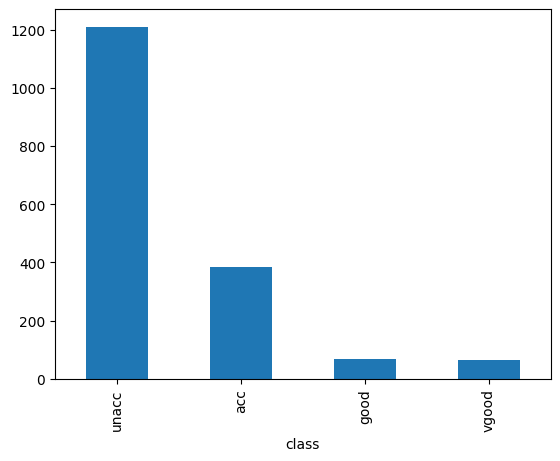

In [29]:
# View the class distribution
df['class'].value_counts().plot(kind='bar')

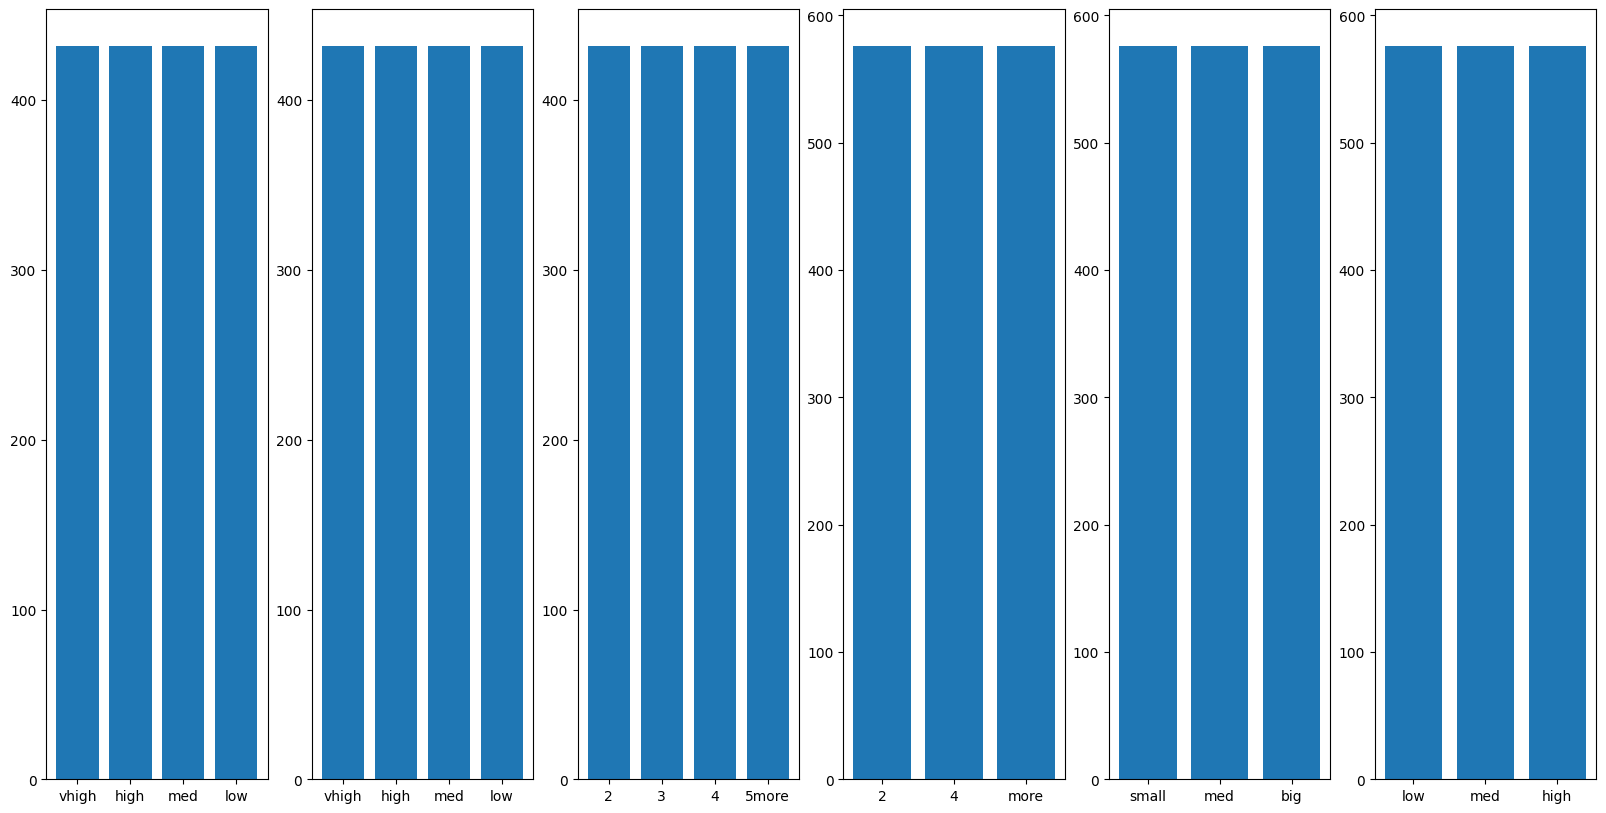

In [30]:
# View the distribution of the features
fig, ax = plt.subplots(1, 6, figsize=(20, 10))

i = 0
for col in df.drop('class', axis=1):
    features_count = df[col].value_counts()
    ax[i].bar(features_count.index, features_count.values)
    i+=1

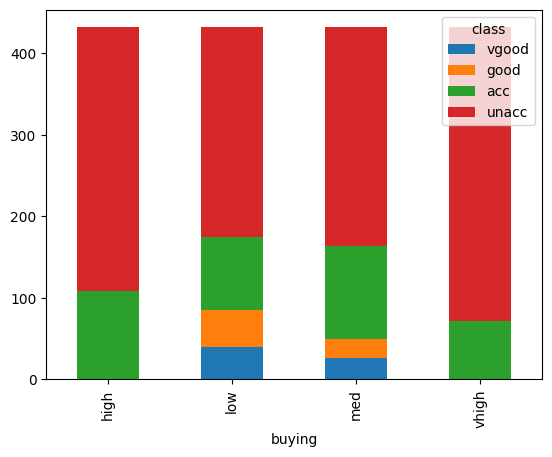

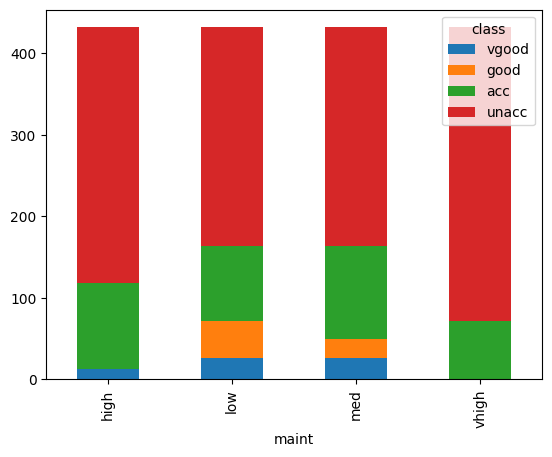

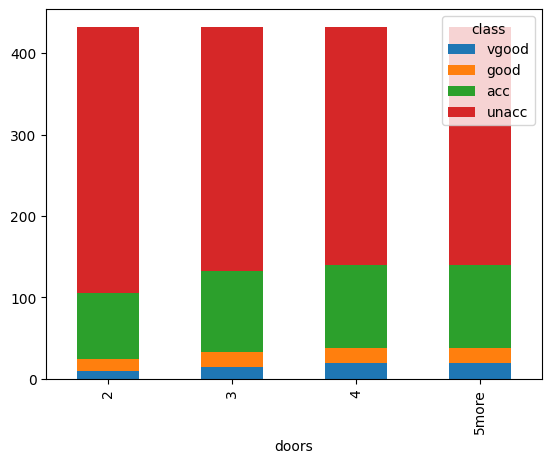

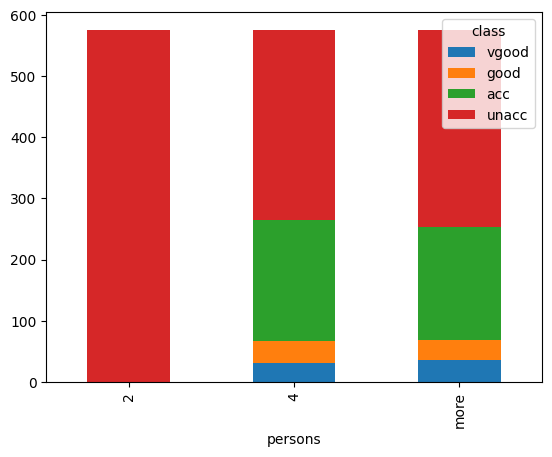

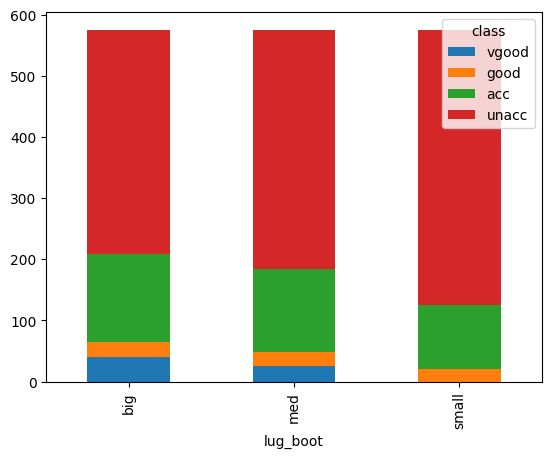

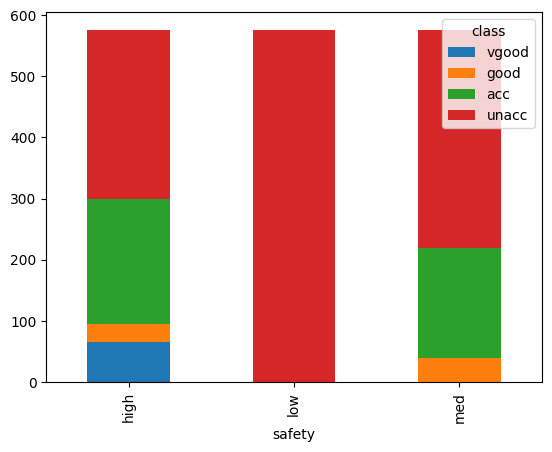

In [31]:
# Bar plot for each feature with distribution based on the class associated with it
# View the distribution of the features

class_options = ['vgood', 'good', 'acc', 'unacc']
columns = ['buying', 'maint', 'doors', 'persons', 'lug_boot', 'safety']

for i, col in enumerate(columns):
    df2 = df.groupby([col, 'class'])[col].count().unstack('class').fillna(0)
    df2[class_options].plot(kind='bar', stacked=True)


The 'safety' and the number of 'persons' seem to have a lot of effect in deciding if a car is unacceptable since the lowest values for the both features result in 100% of unacceptable cars.
The number of doors don't seem to have a significant effect in the car acceptability since the distribution for the various possible values is equal for the various possible outputs. 
When looking at the size of the luggage boot feature, only the medium and big sizes result in a car being very good in terms of acceptability.
For the buying price of the car, only medium and low prices seem to result in very good acceptability, with the high and very high prices only resulting in unnaceptable and acceptable outcomes.

In [32]:
# Categorical features converted into numeric features to try and understand relationship between features and class
# buying: ['vhigh' 'high' 'med' 'low']
# maint: ['vhigh' 'high' 'med' 'low']
# doors: ['2' '3' '4' '5more']
# persons: ['2' '4' 'more']
# lug_boot: ['small' 'med' 'big']
# safety: ['low' 'med' 'high']
# class: ['unacc' 'acc' 'vgood' 'good']


df_viz = df.copy()
df_viz['buying'] = df_viz['buying'].replace({'vhigh': 3, 'high': 2, 'med': 1, 'low': 0})
df_viz['maint'] = df_viz['maint'].replace({'vhigh': 3, 'high': 2, 'med': 1, 'low': 0})
df_viz['doors'] = df_viz['doors'].replace({'5more': 3, '4': 2, '3': 1, '2': 0})
df_viz['persons'] = df_viz['persons'].replace({'more': 2, '4': 1, '2': 0})
df_viz['lug_boot'] = df_viz['lug_boot'].replace({'big': 2, 'med': 1, 'small': 0})
df_viz['safety'] = df_viz['lug_boot'].replace({'big': 2, 'med': 1, 'low': 0})
df_viz['class'] = df_viz['class'].replace({'vgood': 3, 'good': 2, 'acc': 1, 'unacc': 0})


In [33]:
# Pair plots
# TODO

# Split dataset

In [34]:
X = df.drop('class', axis=1)
y = df['class']

# Split dataset before any preprocessing to prevent data leakage
# Use stratify to ensure there are samples of all the classes in the training and testing dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

<BarContainer object of 4 artists>

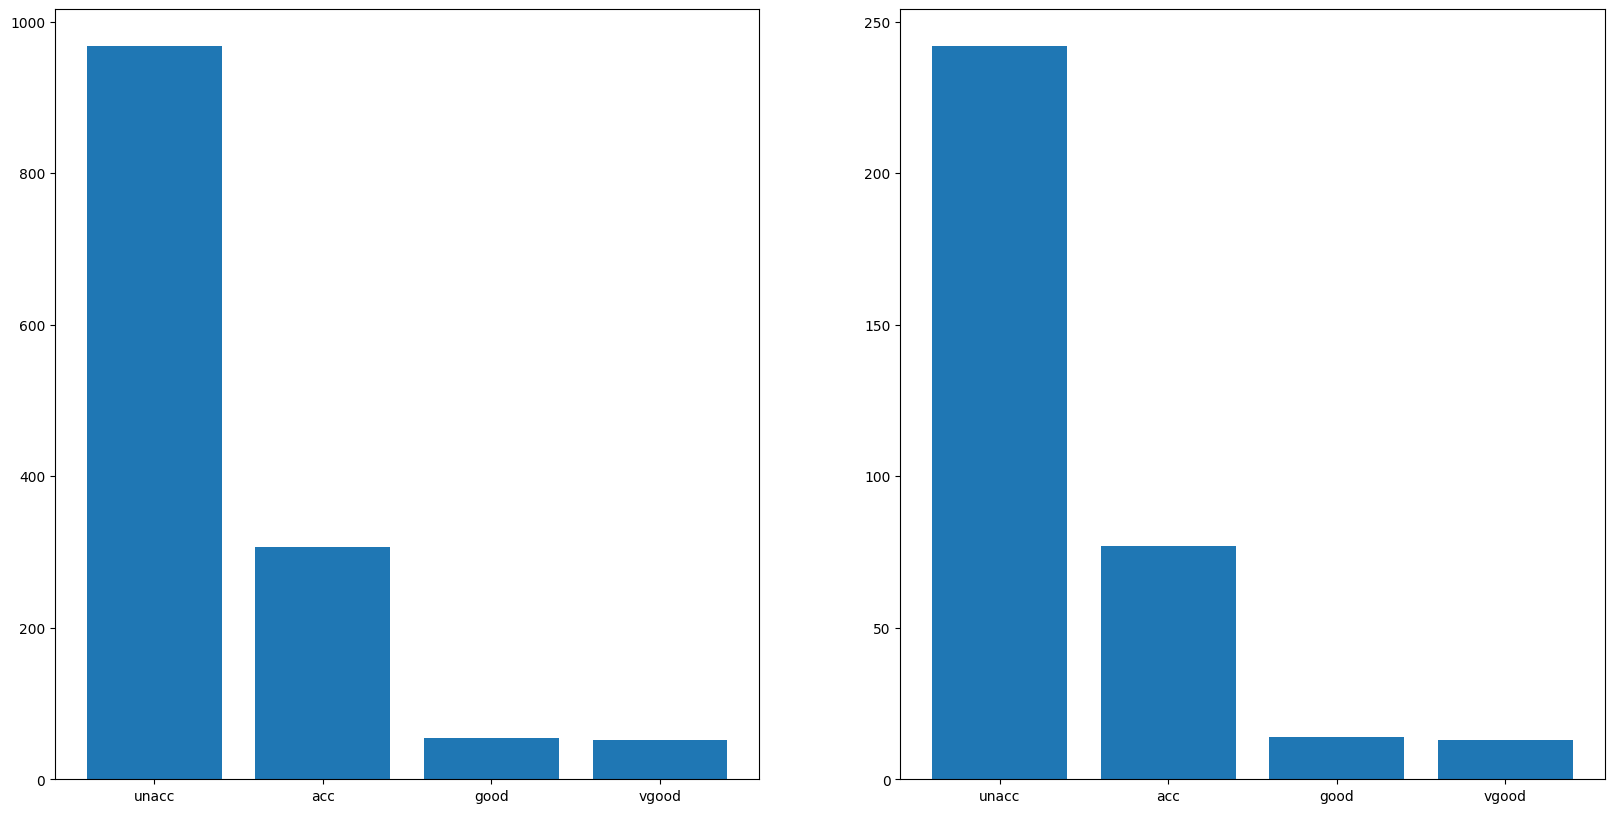

In [35]:
# View class distribution in training and testing dataset
y_train_features = y_train.value_counts()
y_test_features = y_test.value_counts()

fig, ax = plt.subplots(1, 2, figsize=(20, 10))

ax[0].bar(y_train_features.index, y_train_features.values)
ax[1].bar(y_test_features.index, y_test_features.values)

# Pre-processing

In [36]:
# Setup all the encoders

# one hot encoding for labels
label_binarizer = preprocessing.LabelBinarizer()

# one hot encoding categorical features -> suitable for low cardinality
one_hot_encoder = preprocessing.OneHotEncoder(handle_unknown="error")
# ordinal encoding categorical features
ordinal_encoder = preprocessing.OrdinalEncoder()

y_train_binarizer = label_binarizer.fit_transform(y_train)
y_test_binarizer = label_binarizer.transform(y_test)

In [37]:
# Pipeline for feature preprocessing

categorical_preprocessor = Pipeline(steps=[
    ("onehot", preprocessing.OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer([
    ("buying_one_hot", categorical_preprocessor, ["buying"]),
    ("maint_one_hot", categorical_preprocessor, ["maint"]),
    ("doors_one_hot", categorical_preprocessor, ["doors"]),
    ("persons_one_hot", categorical_preprocessor, ["persons"]),
    ("lug_boot_one_hot", categorical_preprocessor, ["lug_boot"]),
    ("safety_one_hot", categorical_preprocessor, ["safety"])
])

In [42]:
logistic_pipe = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("logistic", LogisticRegression())
])


# Decision Tree

In [ ]:
decision_tree_pipe = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("tree", DecisionTreeClassifier())
])

In [45]:
param_grid = {
              'tree__max_depth': [3, 5, 6, 7, 8],
              'tree__criterion': ['gini', 'entropy', 'log_loss']
             }

decision_tree_grid = GridSearchCV(decision_tree_pipe, param_grid=param_grid)
decision_tree_grid.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('buying_one_hot',
                                                                         Pipeline(steps=[('onehot',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         ['buying']),
                                                                        ('maint_one_hot',
                                                                         Pipeline(steps=[('onehot',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         ['maint']),
                                                                        ('doors_one_hot',
                                                                         Pipeline(steps=[('onehot',
                                                                                          OneHotEncoder(handle_unkno...
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         ['persons']),
                                                                        ('lug_boot_one_hot',
                                                                         Pipeline(steps=[('onehot',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         ['lug_boot']),
                                                                        ('safety_one_hot',
                                                                         Pipeline(steps=[('onehot',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         ['safety'])])),
                                       ('tree', DecisionTreeClassifier())]),
             param_grid={'tree__criterion': ['gini', 'entropy', 'log_loss'],
                         'tree__max_depth': [3, 5, 6, 7, 8]})

In [47]:
decision_tree_grid.best_params_

{'tree__criterion': 'gini', 'tree__max_depth': 8}

In [59]:
decision_tree_grid.best_estimator_

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('buying_one_hot',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['buying']),
                                                 ('maint_one_hot',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['maint']),
                                                 ('doors_one_hot',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['doors']),
                                                 ('persons_one_hot',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['persons']),
                                                 ('lug_boot_one_hot',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['lug_boot']),
                                                 ('safety_one_hot',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['safety'])])),
                ('tree', DecisionTreeClassifier(max_depth=8))])

[Text(0.6481854838709677, 0.9444444444444444, 'x[19] <= 0.5\ngini = 0.457\nsamples = 1382\nvalue = [307, 55, 968, 52]'),
 Text(0.6320564516129032, 0.8333333333333334, 'x[12] <= 0.5\ngini = 0.58\nsamples = 917\nvalue = [307, 55, 503, 52]'),
 Text(0.6159274193548387, 0.7222222222222222, 'x[3] <= 0.5\ngini = 0.629\nsamples = 615\nvalue = [307, 55, 201, 52]'),
 Text(0.4213709677419355, 0.6111111111111112, 'x[0] <= 0.5\ngini = 0.629\nsamples = 460\nvalue = [249, 55, 104, 52]'),
 Text(0.2540322580645161, 0.5, 'x[5] <= 0.5\ngini = 0.647\nsamples = 303\nvalue = [159, 55, 37, 52]'),
 Text(0.12903225806451613, 0.3888888888888889, 'x[6] <= 0.5\ngini = 0.551\nsamples = 227\nvalue = [144, 19, 33, 31]'),
 Text(0.06451612903225806, 0.2777777777777778, 'x[17] <= 0.5\ngini = 0.403\nsamples = 149\nvalue = [111, 0, 29, 9]'),
 Text(0.03225806451612903, 0.16666666666666666, 'x[2] <= 0.5\ngini = 0.268\nsamples = 99\nvalue = [84, 0, 6, 9]'),
 Text(0.016129032258064516, 0.05555555555555555, 'gini = 0.369\nsam

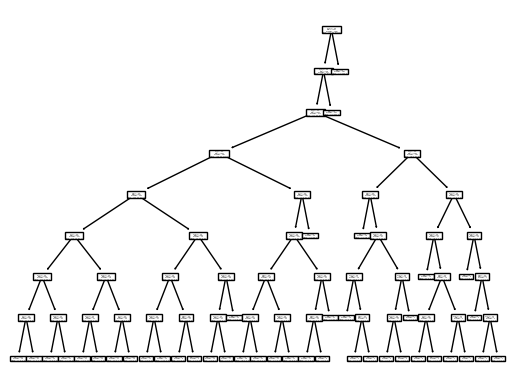

In [64]:
plot_tree(decision_tree_grid.best_estimator_['tree'])

In [62]:
decision_tree_grid.score(X_test, y_test)

0.9364161849710982

In [75]:
y_hat = decision_tree_grid.predict(X_test)
confusion_matrix(y_test, y_hat)

array([[ 68,   1,   7,   1],
       [  4,  10,   0,   0],
       [  5,   0, 237,   0],
       [  4,   0,   0,   9]], dtype=int64)

# SVM

In [66]:
svm_pipe = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("svc", SVC())
])

In [67]:
param_grid = {
              'svc__kernel': ['linear','poly', 'rbf', 'sigmoid'],
              'svc__C': [1, 10, 100, 1000],
              'svc__gamma':[1, 0.1, 0.001, 0.0001]
             }

svm_grid = GridSearchCV(svm_pipe, param_grid=param_grid)
svm_grid.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('buying_one_hot',
                                                                         Pipeline(steps=[('onehot',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         ['buying']),
                                                                        ('maint_one_hot',
                                                                         Pipeline(steps=[('onehot',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         ['maint']),
                                                                        ('doors_one_hot',
                                                                         Pipeline(steps=[('onehot',
                                                                                          OneHotEncoder(handle_unkno...
                                                                         ['persons']),
                                                                        ('lug_boot_one_hot',
                                                                         Pipeline(steps=[('onehot',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         ['lug_boot']),
                                                                        ('safety_one_hot',
                                                                         Pipeline(steps=[('onehot',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         ['safety'])])),
                                       ('svc', SVC())]),
             param_grid={'svc__C': [1, 10, 100, 1000],
                         'svc__gamma': [1, 0.1, 0.001, 0.0001],
                         'svc__kernel': ['linear', 'poly', 'rbf', 'sigmoid']})

In [68]:
svm_grid.best_params_

{'svc__C': 1, 'svc__gamma': 1, 'svc__kernel': 'poly'}

In [69]:
svm_grid.best_estimator_

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('buying_one_hot',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['buying']),
                                                 ('maint_one_hot',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['maint']),
                                                 ('doors_one_hot',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['doors']),
                                                 ('persons_one_hot',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['persons']),
                                                 ('lug_boot_one_hot',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['lug_boot']),
                                                 ('safety_one_hot',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['safety'])])),
                ('svc', SVC(C=1, gamma=1, kernel='poly'))])

In [73]:
y_hat = svm_grid.predict(X_test)
confusion_matrix(y_test, y_hat)

array([[ 77,   0,   0,   0],
       [  1,  13,   0,   0],
       [  0,   0, 242,   0],
       [  0,   0,   0,  13]], dtype=int64)

In [74]:
svm_grid.score(X_test, y_test)

0.9971098265895953

# Logistic Regression